# Clustering words

Clustering of words based on Levenshtein distance.

# K-means

In [66]:
import numpy as np 
words = [
    'apple', 'apply', 'apples', 'applies', 'appliance',
    'banana', 'bananas', 'bannana', 'bannanas', 'banane',
    'cat', 'cats', 'cot', 'cots', 'cut',
    'dog', 'dogs', 'dig', 'digs', 'dag',
    'elephant', 'elephants', 'elegant', 'elegance', 'element',
    'frog', 'frogs', 'frag', 'frags', 'frug'
]

# Labels
labels = np.repeat(np.arange(6), 5)

print("Words:", words)
print("Labels:", labels)
assert(len(words)==len(labels))
true_k= len(np.unique(labels))
print(f"K={true_k}")

Words: ['apple', 'apply', 'apples', 'applies', 'appliance', 'banana', 'bananas', 'bannana', 'bannanas', 'banane', 'cat', 'cats', 'cot', 'cots', 'cut', 'dog', 'dogs', 'dig', 'digs', 'dag', 'elephant', 'elephants', 'elegant', 'elegance', 'element', 'frog', 'frogs', 'frag', 'frags', 'frug']
Labels: [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5]
K=6


In [67]:
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

## TIF-DF encoding

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words="english",
)
X_tfidf = vectorizer.fit_transform(words)

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

n_samples: 30, n_features: 30


In [69]:
from sklearn.cluster import KMeans
import numpy as np

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")


Number of elements assigned to each cluster: [25  1  1  1  1  1]
Number of elements assigned to each cluster: [25  1  1  1  1  1]
Number of elements assigned to each cluster: [25  1  1  1  1  1]
Number of elements assigned to each cluster: [25  1  1  1  1  1]
Number of elements assigned to each cluster: [25  1  1  1  1  1]


In [70]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans on\ntf-idf vectors")

clustering done in 0.13 ± 0.03 s 
Homogeneity: 0.175 ± 0.002
Completeness: 0.436 ± 0.006
V-measure: 0.250 ± 0.003
Adjusted Rand-Index: 0.000 ± 0.004
Silhouette Coefficient: -0.000 ± 0.000


## TIF-DF encoding with LSA reduction

In [71]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=5), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 16.3%


In [72]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans with LSA\non tf-idf vectors")

clustering done in 0.02 ± 0.01 s 
Homogeneity: 0.316 ± 0.034
Completeness: 0.329 ± 0.035
V-measure: 0.322 ± 0.034
Adjusted Rand-Index: 0.025 ± 0.028
Silhouette Coefficient: 0.157 ± 0.035


## Hashing encoding with LSA reduction

In [73]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(words)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 1.334 s


In [74]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans with LSA\non hashed vectors")

clustering done in 0.01 ± 0.00 s 
Homogeneity: 0.232 ± 0.024
Completeness: 0.295 ± 0.055
V-measure: 0.259 ± 0.034
Adjusted Rand-Index: -0.020 ± 0.029
Silhouette Coefficient: -0.000 ± 0.000


## Similarity Clustering

Clustering words based on their similarity as a sequence, using the Levenshtein distance.

In [75]:
import matplotlib.pyplot as plt

def levenshtein_distance(s1, s2):
    # Create a matrix to store distances
    matrix = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

    # Initialize first row and column of the matrix
    for i in range(len(s1) + 1):
        matrix[i][0] = i
    for j in range(len(s2) + 1):
        matrix[0][j] = j

    # Fill the matrix
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            matrix[i][j] = min(matrix[i - 1][j] + 1,       # Deletion
                               matrix[i][j - 1] + 1,       # Insertion
                               matrix[i - 1][j - 1] + cost)  # Substitution

    # Return the bottom-right cell of the matrix
    return matrix[len(s1)][len(s2)]

# Example usage:

def create_dist_matrix(word_list):
    matrix = [[0] * (len(word_list)) for _ in range(len(word_list))]
    for i in range(0, len(word_list) ):
        for j in range(0, len(word_list)):
           matrix[i][j] =  levenshtein_distance(word_list[i],word_list[j])
    return matrix

dist_matrix = create_dist_matrix(words)
min_val = min(min(row) for row in dist_matrix)
max_val = max(max(row) for row in dist_matrix)

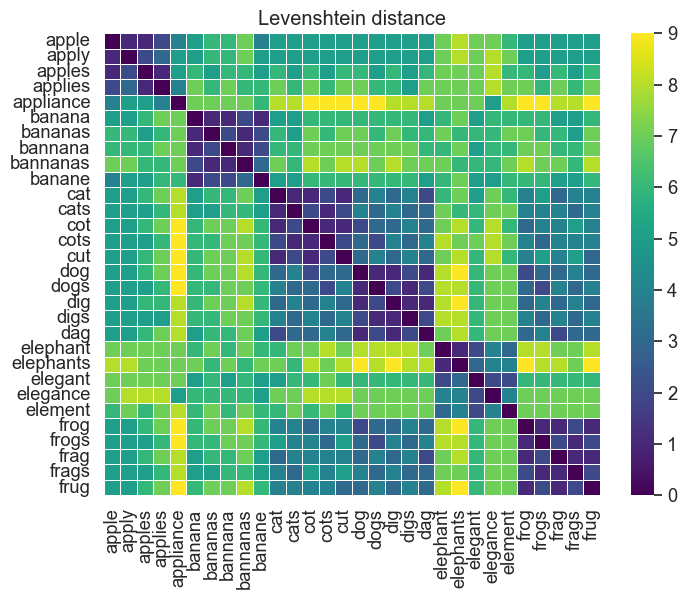

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(matrix, row_labels, col_labels):
    sns.set(font_scale=1.2)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(matrix, cmap='viridis', fmt=".2f", linewidths=.5, 
                     xticklabels=col_labels, yticklabels=row_labels)
    plt.title('Levenshtein distance')
    plt.show()

plot_heatmap(dist_matrix,words,words)

In [77]:
# ----------------------
#       imports
# ----------------------
# import opencv
import cv2 as cv
# matplotlib
import matplotlib.pyplot as plt

# make AntClus dir known
import sys
sys.path.append("../AntClust")
# import AntClust
from AntClust import AntClust
from importlib import reload

# import the precomputed distance matrix function for AntClust
import distance_classes
reload(distance_classes)# import the rule set
from rules import labroche_rules

# ----------------------
#       AntClust
# ----------------------
# tell AntClust to treat the data set as precomputed similarity matrix
# similarity function
f_sim = [distance_classes.levenshtein_distance(min_val,max_val)]
ant_clust = AntClust(f_sim, labroche_rules())
ant_clust.fit([[i] for i in words])
clusters_found = ant_clust.get_clusters()

AntClust: phase 1 of 3 -> meeting ants
left meetings  2250 / 2250
left meetings  2025 / 2250
left meetings  1800 / 2250
left meetings  1575 / 2250
left meetings  1350 / 2250
left meetings  1125 / 2250
left meetings  900 / 2250
left meetings  675 / 2250
left meetings  450 / 2250
left meetings  225 / 2250
AntClust: phase 2 of 3 -> shrink nests
AntClust: phase 3 of 3 -> reassign ants


In [78]:
# show clusters
grouped_words = {}
for i in set(clusters_found):
    grouped_words[i] = []
for i in range(len(clusters_found)):
    grouped_words[clusters_found[i]].append(words[i])
for key in grouped_words.keys():
    print(f"Cluster {key}:",grouped_words[key])

Cluster 0: ['apple', 'apply', 'apples', 'applies', 'appliance']
Cluster 1: ['banana', 'bananas', 'bannana', 'bannanas', 'banane']
Cluster 2: ['cat', 'cats', 'cot', 'cots', 'cut']
Cluster 3: ['dog', 'frog', 'frogs', 'frag', 'frags', 'frug']
Cluster 4: ['dogs', 'dig', 'digs', 'dag']
Cluster 5: ['elephant', 'elephants', 'elegant', 'elegance', 'element']


In [79]:
import pandas as pd

name = "AntClust\nLevenshtein distance"
scores = defaultdict(list)
homogeneity_score = metrics.homogeneity_score(labels, clusters_found)
completeness_score = metrics.completeness_score(labels, clusters_found)
v_score = metrics.v_measure_score(labels, clusters_found)
ari_score = metrics.adjusted_rand_score(labels, clusters_found)

print(f"Homogeneity: {homogeneity_score}")
print(f"Completeness: {completeness_score}")
print(f"V-measure: {v_score}")
print(f"Adjusted Rand-Index: {ari_score}")

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

data = {
    'Homogeneity': homogeneity_score,
    'Completeness': completeness_score,
    'V-measure': v_score,
    'Adjusted Rand-Index': ari_score,
}

# Creating a new DataFrame with the data for the new row
new_row = pd.DataFrame(data, index=[name])

# Concatenate the new row with the original DataFrame
df = pd.concat([df, new_row])

Homogeneity: 0.949707400283988
Completeness: 0.9532783313694229
V-measure: 0.9514895154209182
Adjusted Rand-Index: 0.913604766633565


### Results


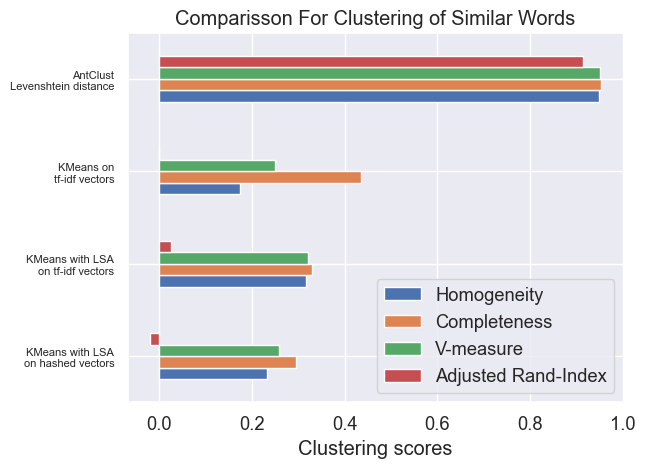

In [80]:
ax = df.drop(
    ["train_time", "Silhouette Coefficient"],
    axis="columns",
).plot.barh()
plt.xlabel("Clustering scores")
plt.ylabel("")
ax.tick_params(axis='y', labelsize=8) 
plt.title("Comparisson For Clustering of Similar Words")
plt.show()

In [81]:
df.drop(
    ["train_time", "Silhouette Coefficient"],
    axis="columns",
)

,Homogeneity,Completeness,V-measure,Adjusted Rand-Index
KMeans with LSA\non hashed vectors,0.231582,0.295393,0.258886,-0.019937
KMeans with LSA\non tf-idf vectors,0.315513,0.328625,0.321905,0.024780
KMeans on\ntf-idf vectors,0.175018,0.436269,0.249817,0.000149
AntClust\nLevenshtein distance,0.949707,0.953278,0.951490,0.913605
